## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96-aux-balanced/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux-balanced/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux-balanced/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux-balanced/fold_3.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux-balanced/fold_4.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-roberta-base-96-aux-balanced/fold_5.tar.gz

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,6c3221ae9b,so instead of laying out in this 90 degrees i`...,fml,negative,0.052632,115,3,21,1,train,validation,train,train,train
1,6d059e310b,hitting the (fairly empty) shops in orlando! o...,hitting,negative,0.076923,100,7,14,1,train,train,train,validation,train
2,ce7f8a5210,spent some time with the guild wars 4th birthd...,welcome,positive,0.052632,114,7,19,1,validation,train,train,train,train
3,456c4304cd,first weekend at home,first weekend at home,neutral,1.000000,21,21,4,4,train,validation,train,train,train
4,6b78e2821a,would like june the nineteenth to hurry it sel...,she is waiting very impatiently,negative,0.263158,102,31,20,5,train,train,train,train,validation


fold_1/
fold_1/y_valid.npy
fold_1/x_valid_aux.npy
fold_1/y_train.npy
fold_1/x_train_aux2.npy
fold_1/x_train.npy
fold_1/y_train_aux.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux.npy
fold_1/x_valid.npy
fold_1/y_valid_mask.npy
fold_1/x_valid_aux2.npy
fold_1/y_valid_aux.npy
fold_2/
fold_2/y_valid.npy
fold_2/x_valid_aux.npy
fold_2/y_train.npy
fold_2/x_train_aux2.npy
fold_2/x_train.npy
fold_2/y_train_aux.npy
fold_2/y_train_mask.npy
fold_2/x_train_aux.npy
fold_2/x_valid.npy
fold_2/y_valid_mask.npy
fold_2/x_valid_aux2.npy
fold_2/y_valid_aux.npy
fold_3/
fold_3/y_valid.npy
fold_3/x_valid_aux.npy
fold_3/y_train.npy
fold_3/x_train_aux2.npy
fold_3/x_train.npy
fold_3/y_train_aux.npy
fold_3/y_train_mask.npy
fold_3/x_train_aux.npy
fold_3/x_valid.npy
fold_3/y_valid_mask.npy
fold_3/x_valid_aux2.npy
fold_3/y_valid_aux.npy
fold_4/
fold_4/y_valid.npy
fold_4/x_valid_aux.npy
fold_4/y_train.npy
fold_4/x_train_aux2.npy
fold_4/x_train.npy
fold_4/y_train_aux.npy
fold_4/y_train_mask.npy
fold_4/x_train_aux.npy
fo

# Model parameters

In [3]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 96,
  'BATCH_SIZE': 32,
  'EPOCHS': 5,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 1,
  'question_size': 4,
  'N_FOLDS': 5,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [4]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.87e-06


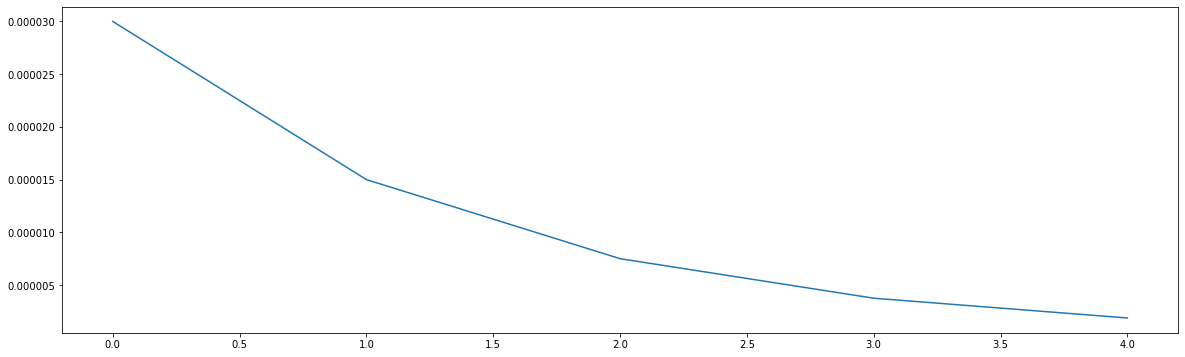

In [5]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [6]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    x_start = layers.Dropout(.1)(last_hidden_state) 
    x_start = layers.Dense(1)(x_start)
    x_start = layers.Flatten()(x_start)
    y_start = layers.Activation('softmax', name='y_start')(x_start)

    x_end = layers.Dropout(.1)(last_hidden_state) 
    x_end = layers.Dense(1)(x_end)
    x_end = layers.Flatten()(x_end)
    y_end = layers.Activation('softmax', name='y_end')(x_end)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[y_start, y_end])
    
    return model

# Train

In [7]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss_start = loss_fn_start(y['y_start'], probabilities[0], label_smoothing=0.2)
                loss_end = loss_fn_end(y['y_end'], probabilities[1], label_smoothing=0.2)
                loss = tf.math.add(loss_start, loss_end)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_acc_start.update_state(y['y_start'], probabilities)
            train_acc_end.update_state(y['y_end'], probabilities)
            train_loss.update_state(loss)
            train_loss_start.update_state(loss_start)
            train_loss_end.update_state(loss_end)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss_start = loss_fn_start(y['y_start'], probabilities[0])
            loss_end = loss_fn_end(y['y_end'], probabilities[1])
            loss = tf.math.add(loss_start, loss_end)
            # update metrics
            valid_acc_start.update_state(y['y_start'], probabilities)
            valid_acc_end.update_state(y['y_end'], probabilities)
            valid_loss.update_state(loss)
            valid_loss_start.update_state(loss_start)
            valid_loss_end.update_state(loss_end)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: lrfn(tf.cast(optimizer.iterations, tf.float32)//step_size))
    loss_fn_start = losses.categorical_crossentropy
    loss_fn_end = losses.categorical_crossentropy

    train_acc_start = metrics.CategoricalAccuracy()
    valid_acc_start = metrics.CategoricalAccuracy()
    train_acc_end = metrics.CategoricalAccuracy()
    valid_acc_end = metrics.CategoricalAccuracy()
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
    train_loss_start = metrics.Sum()
    valid_loss_start = metrics.Sum()
    train_loss_end = metrics.Sum()
    valid_loss_end = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'loss_start': train_loss_start, 'loss_end': train_loss_end, 
                    'acc_start': train_acc_start, 'acc_end': train_acc_end, 
                    'val_loss': valid_loss, 'val_loss_start': valid_loss_start, 'val_loss_end': valid_loss_end, 
                    'val_acc_start': valid_acc_start, 'val_acc_end': valid_acc_end}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], model_path)
    
    history_list.append(history)
    model.load_weights(model_path)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = train_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = train_preds[1].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = valid_preds[0].argmax(axis=-1)
    k_fold.loc[k_fold['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = valid_preds[1].argmax(axis=-1)
    
    k_fold['end_fold_%d' % (n_fold)] = k_fold['end_fold_%d' % (n_fold)].astype(int)
    k_fold['start_fold_%d' % (n_fold)] = k_fold['start_fold_%d' % (n_fold)].astype(int)
    k_fold['end_fold_%d' % (n_fold)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold)].clip(0, k_fold['end_fold_%d' % (n_fold)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold)].fillna(k_fold["text"], inplace=True)
    k_fold['jaccard_fold_%d' % (n_fold)] = k_fold.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)


FOLD: 1
Train for 583 steps, validate for 145 steps

EPOCH 1/5
time: 243.8s loss: 4.6261 loss_start: 2.3010 loss_end: 2.3251 acc_start: 0.3660 acc_end: 0.3669 val_loss: 2.1480 val_loss_start: 1.1126 val_loss_end: 1.0354 val_acc_start: 0.3738 val_acc_end: 0.3819
Saved model weights at "model_fold_1.h5"

EPOCH 2/5
time: 227.9s loss: 4.1253 loss_start: 2.0860 loss_end: 2.0394 acc_start: 0.4151 acc_end: 0.4303 val_loss: 2.0182 val_loss_start: 1.0478 val_loss_end: 0.9704 val_acc_start: 0.3877 val_acc_end: 0.3983
Saved model weights at "model_fold_1.h5"

EPOCH 3/5
time: 228.4s loss: 3.9811 loss_start: 2.0134 loss_end: 1.9677 acc_start: 0.4326 acc_end: 0.4426 val_loss: 1.9906 val_loss_start: 1.0315 val_loss_end: 0.9591 val_acc_start: 0.4280 val_acc_end: 0.4236
Saved model weights at "model_fold_1.h5"

EPOCH 4/5
time: 228.3s loss: 3.9177 loss_start: 1.9839 loss_end: 1.9338 acc_start: 0.4372 acc_end: 0.4498 val_loss: 2.0705 val_loss_start: 1.0801 val_loss_end: 0.9905 val_acc_start: 0.4143 val_

# Model loss graph

Fold: 1


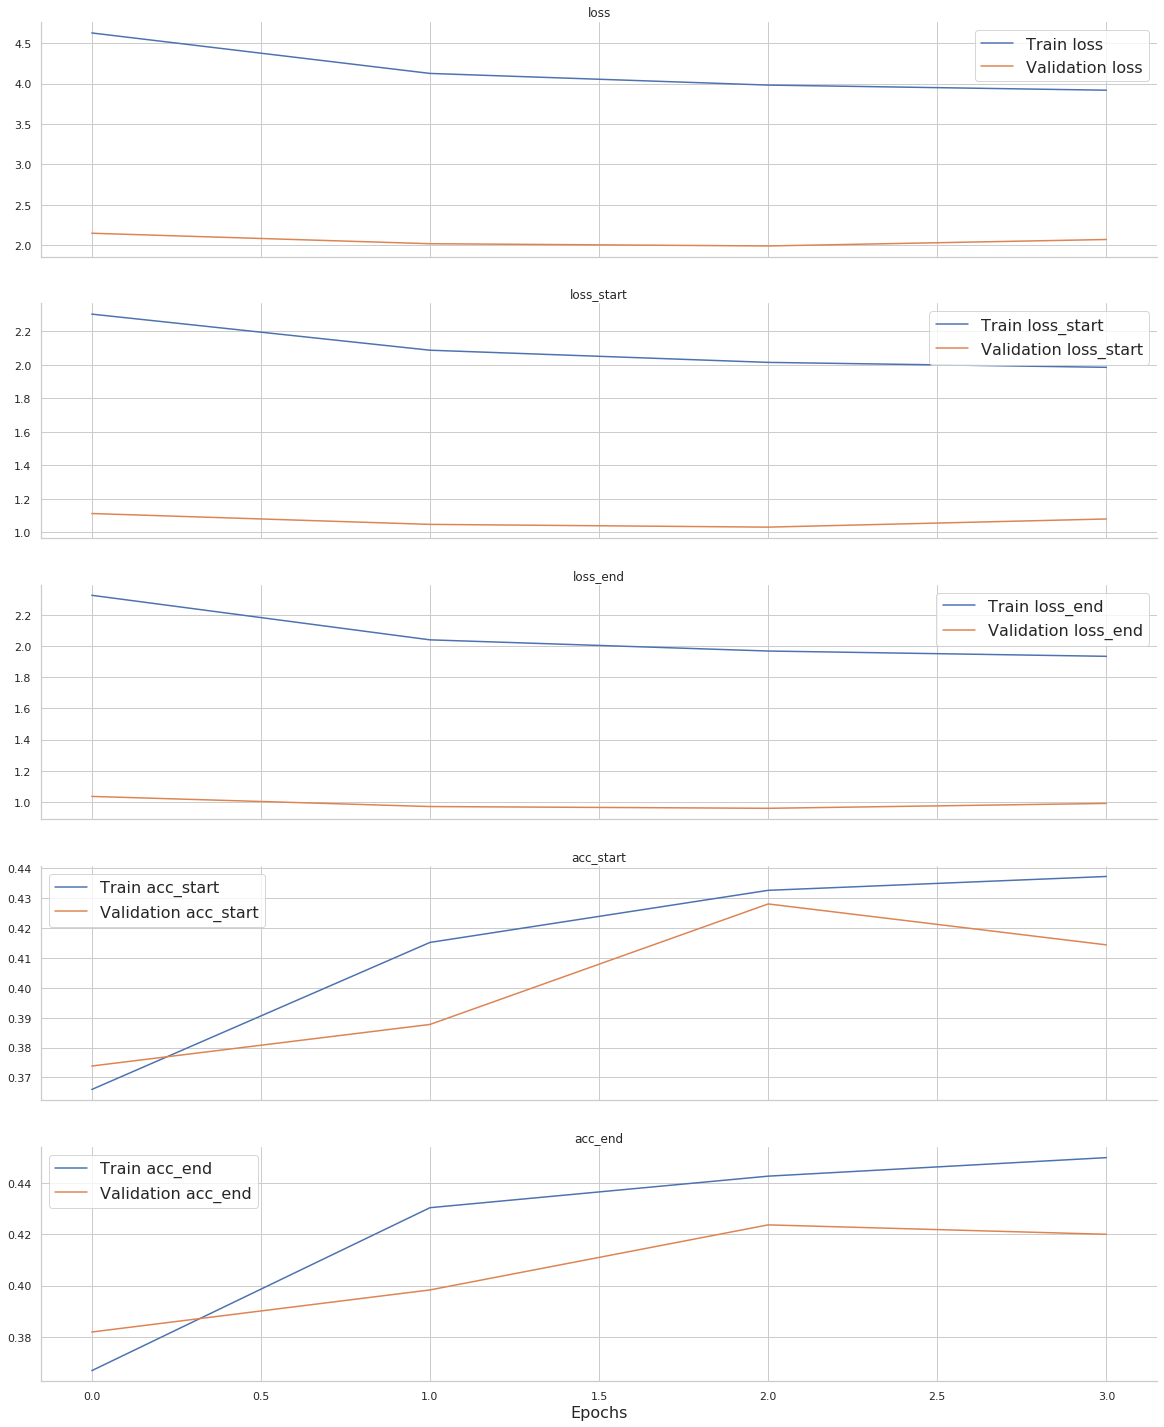

Fold: 2


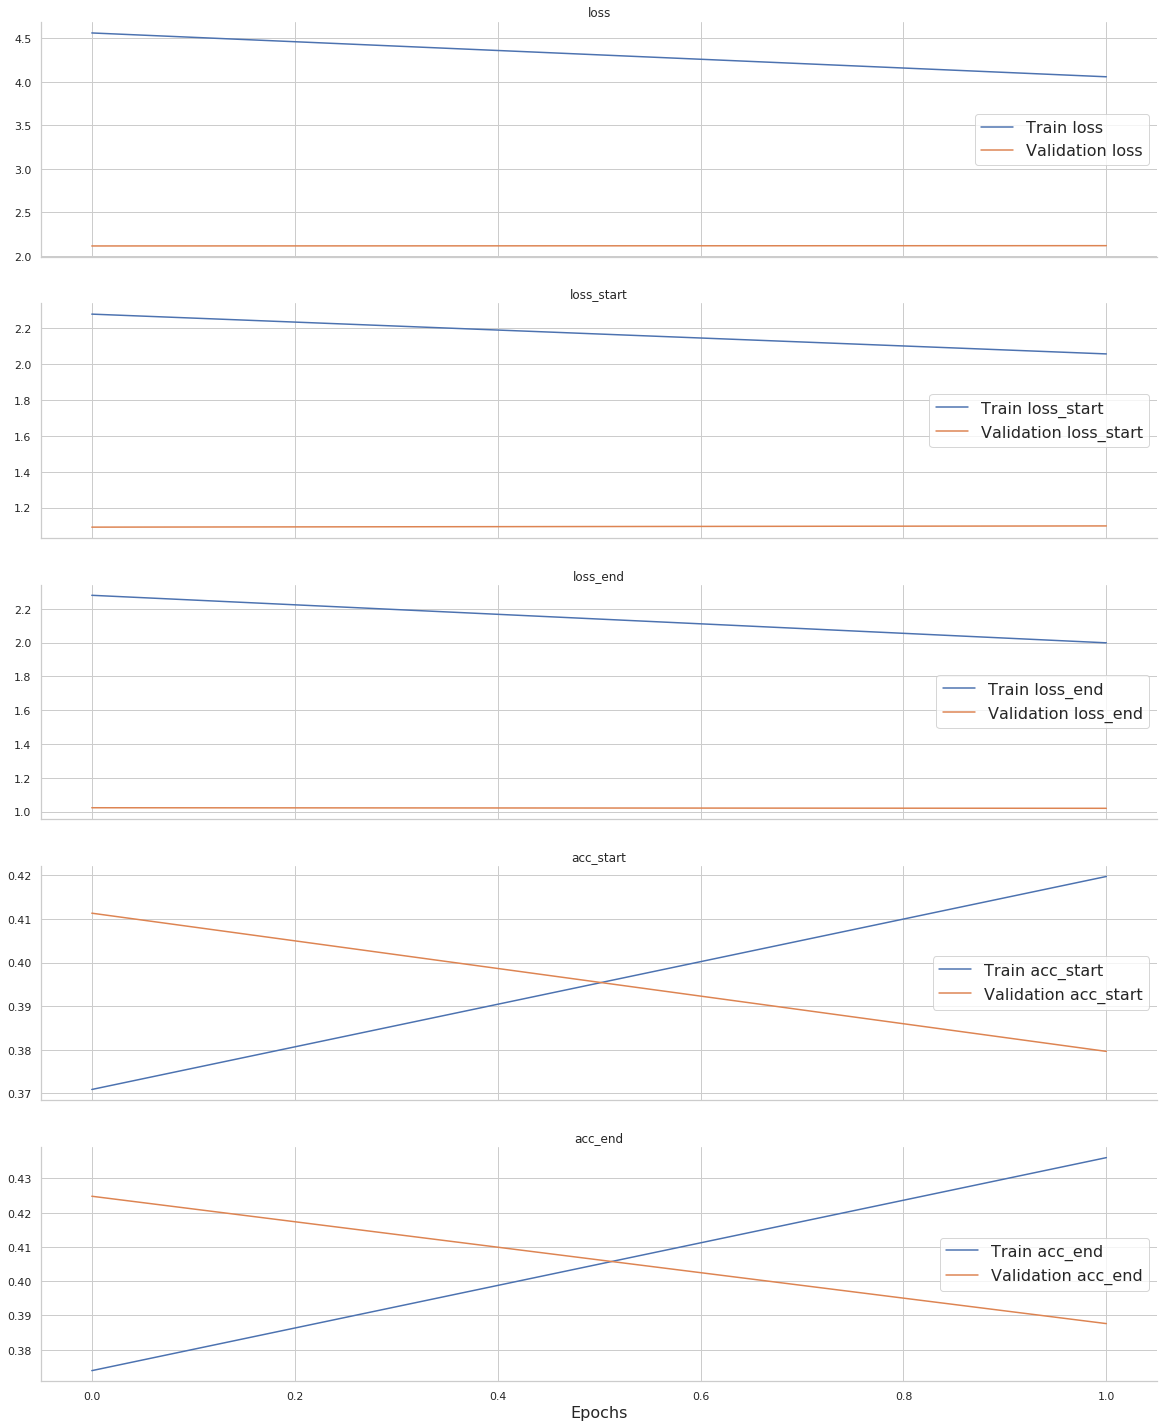

Fold: 3


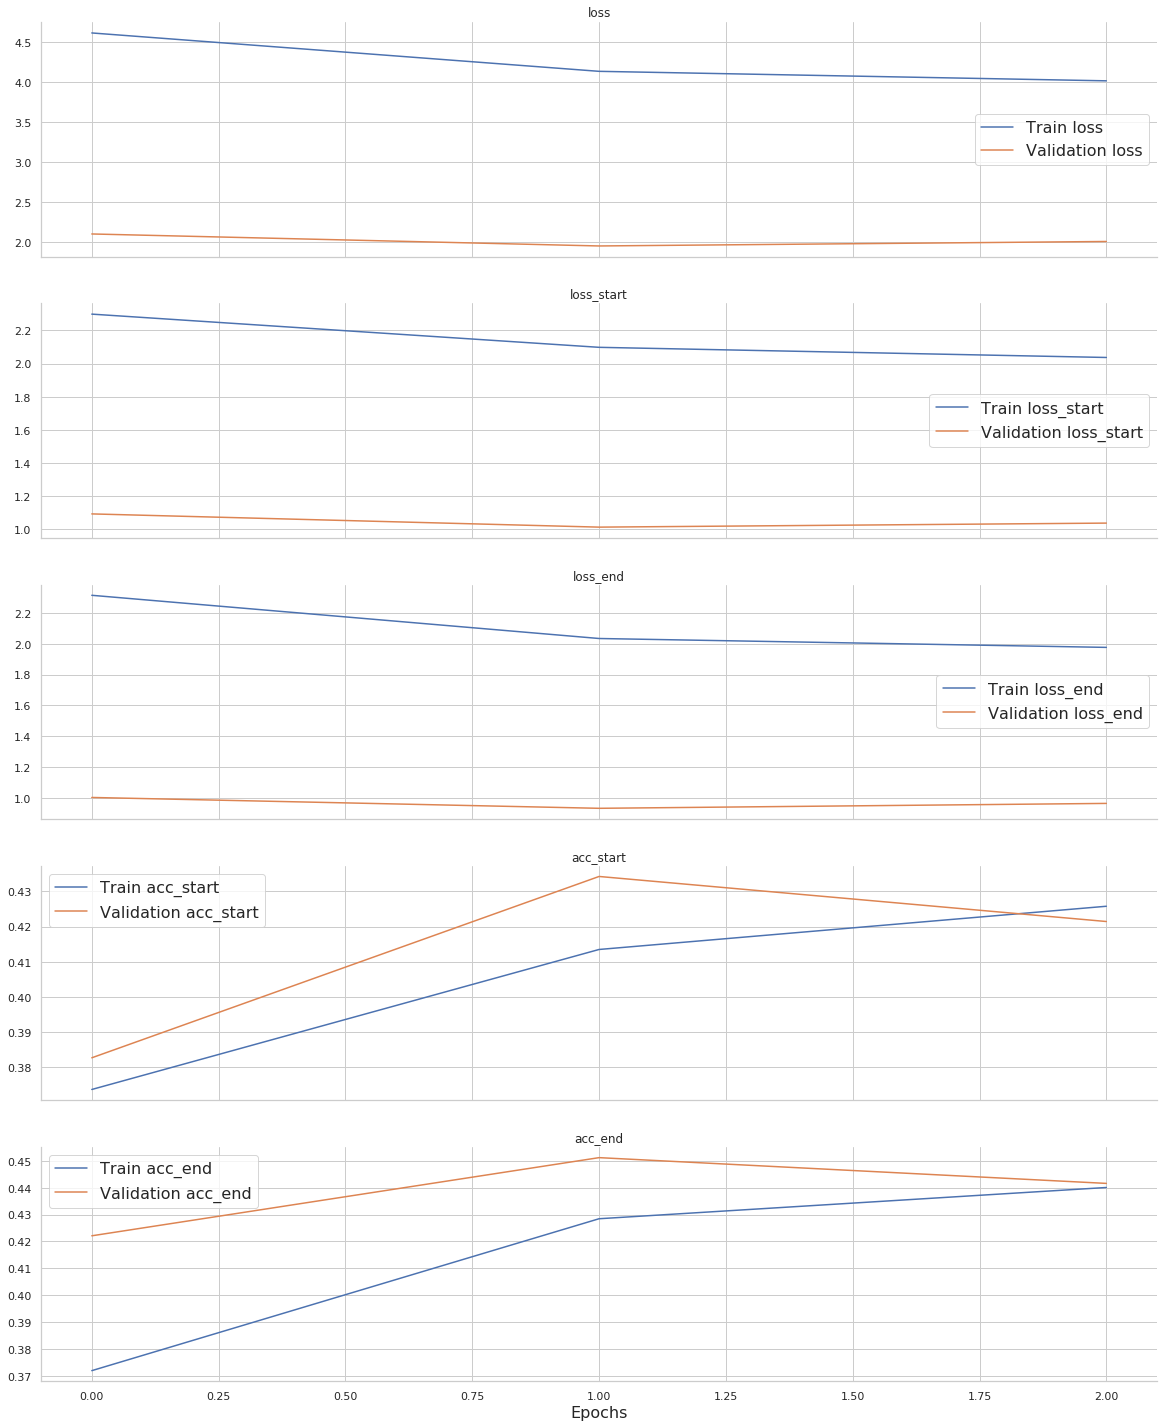

Fold: 4


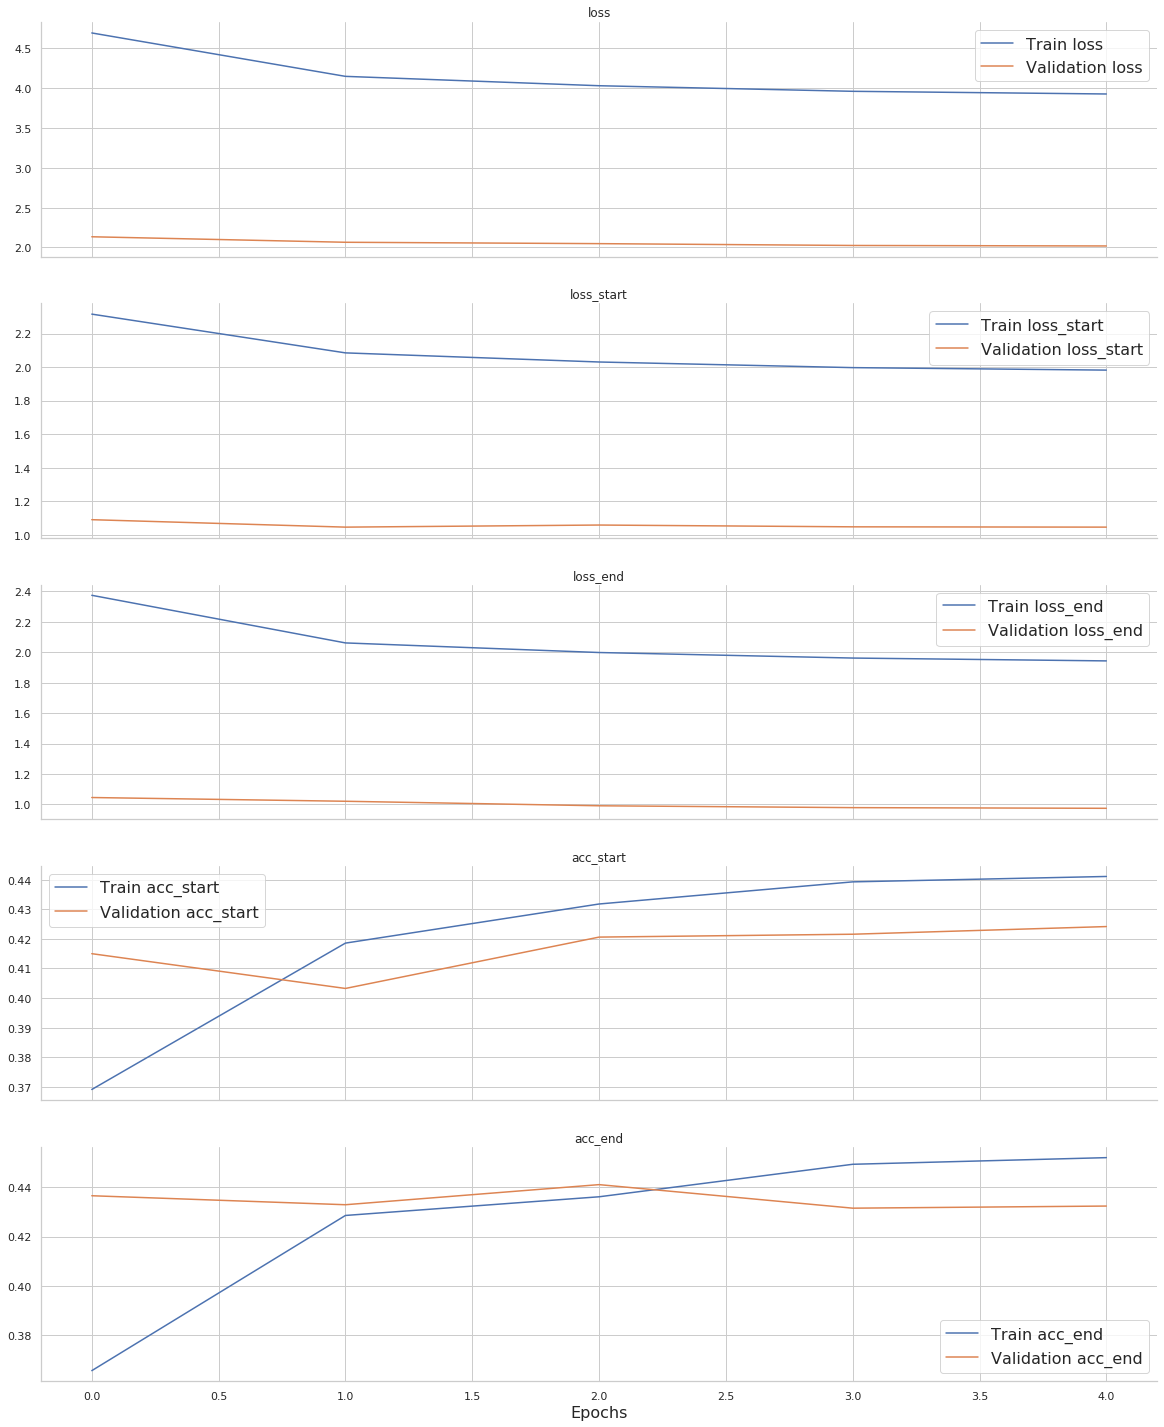

Fold: 5


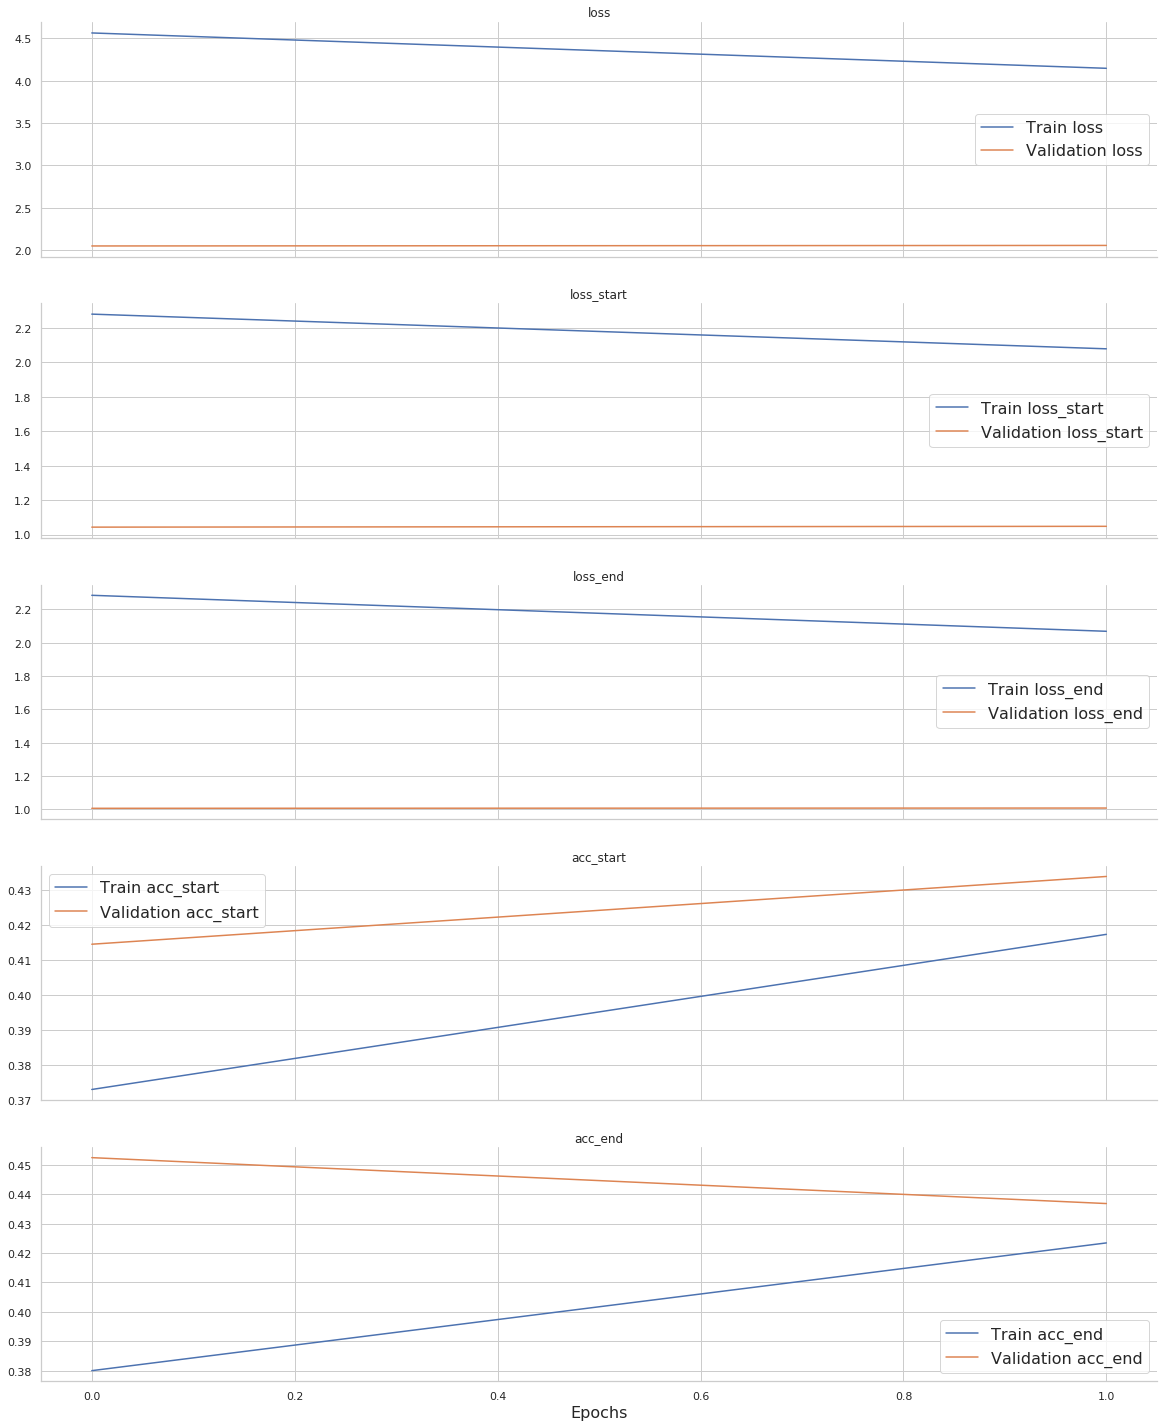

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.704530,0.670277,0.034253,0.723325,0.681007,0.689199,0.660891,0.702828,0.672051,0.733207,0.678319,0.674090,0.659117
Sentiment negative,0.573444,0.518421,0.055023,0.600852,0.553596,0.545495,0.500304,0.575332,0.501768,0.617244,0.529707,0.528297,0.506732
Sentiment neutral,0.974431,0.973552,0.000879,0.975138,0.973303,0.972503,0.975042,0.974063,0.975116,0.975742,0.972420,0.974707,0.971879
Sentiment positive,0.565750,0.518894,0.046856,0.594005,0.516205,0.549623,0.507425,0.559133,0.539270,0.606674,0.532829,0.519316,0.498741
0 <= text wordCnt < 3,0.849180,0.834586,0.014595,0.858531,0.847222,0.852662,0.828431,0.854552,0.813648,0.846442,0.866959,0.833713,0.816667
3 <= text wordCnt < 10,0.760370,0.735542,0.024829,0.774497,0.744277,0.745568,0.729300,0.759339,0.728877,0.782871,0.741930,0.739577,0.733324
10 <= text wordCnt < 30,0.670689,0.631287,0.039402,0.692417,0.643109,0.653995,0.620940,0.668573,0.637765,0.703652,0.639404,0.634806,0.615217
30 <= text wordCnt < 100,0.613823,0.532343,0.081480,0.618914,0.523898,0.605989,0.572619,0.627083,0.444024,0.653831,0.539106,0.563301,0.582070
0 <= selected text wordCnt < 3,0.665945,0.612747,0.053198,0.676542,0.601708,0.641110,0.597262,0.698077,0.645272,0.711174,0.628985,0.602821,0.590507


# Visualize predictions

In [10]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,so instead of laying out in this 90 degrees i`...,fml,negative,0.052632,fml,1.000000,so instead of laying out in this 90 degrees i`...,0.052632,fml,1.000000,fml,1.000000,so instead of laying out in this 90 degrees i`...,0.052632
1,hitting the (fairly empty) shops in orlando! o...,hitting,negative,0.076923,hitting,1.000000,empty),0.000000,hitting,1.000000,empty),0.000000,hitting,1.000000
2,spent some time with the guild wars 4th birthd...,welcome,positive,0.052632,welcome,1.000000,welcome,1.000000,welcome,1.000000,welcome,1.000000,welcome new feature... for rangers anyway.,0.166667
3,first weekend at home,first weekend at home,neutral,1.000000,first weekend at home,1.000000,first weekend at home,1.000000,first weekend at home,1.000000,first weekend at home,1.000000,first weekend at home,1.000000
4,would like june the nineteenth to hurry it sel...,she is waiting very impatiently,negative,0.263158,impatiently,0.200000,impatiently,0.200000,impatiently,0.200000,impatiently,0.200000,impatiently,0.200000
5,you realize you just did a solid. better than...,you realize you just did a solid. better than...,positive,1.000000,better,0.083333,better,0.083333,better,0.083333,better,0.083333,better than a full-page in the ajc.,0.583333
6,still a bit of a warning signal in my head say...,still a bit of a warning signal in my head,negative,0.428571,warning,0.111111,warning,0.111111,warning,0.111111,warning,0.111111,warning,0.111111
7,im finally going home but didnt get to finish ...,im finally going home but didnt get to finish ...,neutral,1.000000,im finally going home but didnt get to finish ...,1.000000,im finally going home but didnt get to finish ...,1.000000,im finally going home but didnt get to finish ...,1.000000,im finally going home but didnt get to finish ...,1.000000,im finally going home but didnt get to finish ...,1.000000
8,is actually feeling awake today,is actually feeling awake today,neutral,1.000000,is actually feeling awake today,1.000000,is actually feeling awake today,1.000000,is actually feeling awake today,1.000000,is actually feeling awake today,1.000000,is actually feeling awake today,1.000000
9,sorry friends - i`m swamped with deadlines ri...,sorry friends,negative,0.100000,sorry,0.500000,sorry,0.500000,sorry,0.500000,sorry,0.500000,sorry friends - i`m swamped with deadlines ri...,0.100000
